# cattle Weight estimation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [2]:
import os
import shutil
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np

# === Configuration ===
IMG_WIDTH = 1280
IMG_HEIGHT = 1280
BATCH_SIZE = 12

# === Original image folder and CSV ===
IMAGE_FOLDER = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\side view"
EXCEL_PATH = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\measurements.csv"

# === Output split folders ===
SPLIT_IMAGE_ROOT = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset"
os.makedirs(os.path.join(SPLIT_IMAGE_ROOT, "train"), exist_ok=True)
os.makedirs(os.path.join(SPLIT_IMAGE_ROOT, "val"), exist_ok=True)
os.makedirs(os.path.join(SPLIT_IMAGE_ROOT, "test"), exist_ok=True)

# === Load labels from CSV ===
df = pd.read_csv(EXCEL_PATH)
df = df.dropna()

# === Split Dataset ===
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# === Function to copy matching PNGs ===
def copy_images(df_split, split_name):
    dest_folder = os.path.join(SPLIT_IMAGE_ROOT, split_name)
    for _, row in df_split.iterrows():
        img_name = f"{int(row['Num'])}.png"
        src_path = os.path.join(IMAGE_FOLDER, img_name)
        dst_path = os.path.join(dest_folder, img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"⚠️ Image not found: {src_path}")

# === Copy images ===
copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")

# === Custom Dataset Class ===
class CattleDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.df = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = f"{int(row['Num'])}.png"
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row["Body weight (kg)"]
        return image, label

# === Transformations ===
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ToTensor()
])

# === Datasets and Loaders for Split Folders ===
train_dataset = CattleDataset(train_df, os.path.join(SPLIT_IMAGE_ROOT, "train"), transform)
validation_dataset = CattleDataset(val_df, os.path.join(SPLIT_IMAGE_ROOT, "val"), transform)
test_dataset = CattleDataset(test_df, os.path.join(SPLIT_IMAGE_ROOT, "test"), transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === Display Dataset Info ===
def display_dataset_info(loader, dataset_name):
    print(f"\n{dataset_name} Dataset:")
    print(f"Total images: {len(loader.dataset)}")

display_dataset_info(train_loader, "Training")
display_dataset_info(validation_loader, "Validation")
display_dataset_info(test_loader, "Test")


Training Dataset:
Total images: 50

Validation Dataset:
Total images: 11

Test Dataset:
Total images: 11


In [3]:
import os
import numpy as np
from PIL import Image
import albumentations as albu

# Original and destination folders
source_folder = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\side view"
augmented_folder = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image"

# Create augmented folder if it doesn't exist
os.makedirs(augmented_folder, exist_ok=True)

# Define augmentation techniques
transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 5), p=0.5)
])

# Function to augment and save
def augment_and_save_to_folder(src_folder, dest_folder):
    for file in os.listdir(src_folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            src_path = os.path.join(src_folder, file)
            try:
                # Load and augment image
                original_image = np.array(Image.open(src_path).convert("RGB"))
                augmented_image = transform(image=original_image)['image']

                # Save to destination folder with new name
                new_filename = f"aug_{file}"
                dest_path = os.path.join(dest_folder, new_filename)
                Image.fromarray(augmented_image).save(dest_path)

                print(f"✅ Augmented saved: {dest_path}")

            except Exception as e:
                print(f"❌ Failed on {src_path}: {e}")

# Run the function
augment_and_save_to_folder(source_folder, augmented_folder)

✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_1.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_10.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_11.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_12.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_13.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_14.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_15.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_16.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_17.png
✅ Augmented saved: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\aug image\aug_18.png
✅

# Pre_Trained RCNN

In [4]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained weights
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights, progress=False).to(device).eval()

# Quantize the model
import torch.quantization as quant
quantized_model = quant.quantize_dynamic(
    model,
    {torch.nn.Conv2d, torch.nn.BatchNorm2d, torch.nn.ReLU},
    dtype=torch.qint8
).to(device).eval()

In [5]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np

def filter_model_output(output, score_threshold):
    filtered_output = []
    for image in output:
        filtered = {}
        for key in image:
            filtered[key] = image[key][image['scores'] >= score_threshold]
        filtered_output.append(filtered)
    return filtered_output

def get_boolean_mask(output):
    for i, pred in enumerate(output):
        output[i]['masks'] = pred['masks'] > 0.5
        output[i]['masks'] = output[i]['masks'].squeeze(1)
    return output

def mshow(imgs, masks=None):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols=len(imgs), nrows=2, squeeze=False, figsize=(12, 12))

    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        if masks is not None:
            mask = masks[i]
            axs[1, i].imshow(mask, cmap='viridis', alpha=0.7)
            axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.show()

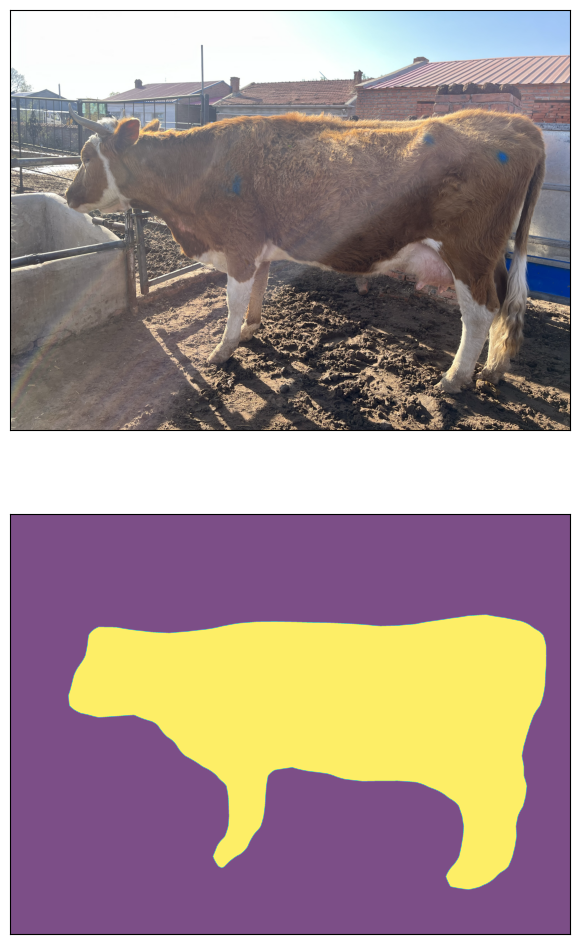

In [6]:
from PIL import Image

# Load image
image_path = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\side view\1.png"
image = Image.open(image_path).convert("RGB")
image_tensor = TF.to_tensor(image).to(device)

# Run inference
with torch.no_grad():
    output = quantized_model([image_tensor])
    output = filter_model_output(output, score_threshold=0.8)
    output = get_boolean_mask(output)

# Visualize
mshow(image_tensor.cpu(), [output[0]['masks'][0].cpu()])

# Training Dataset (Segmentation )

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\12.png


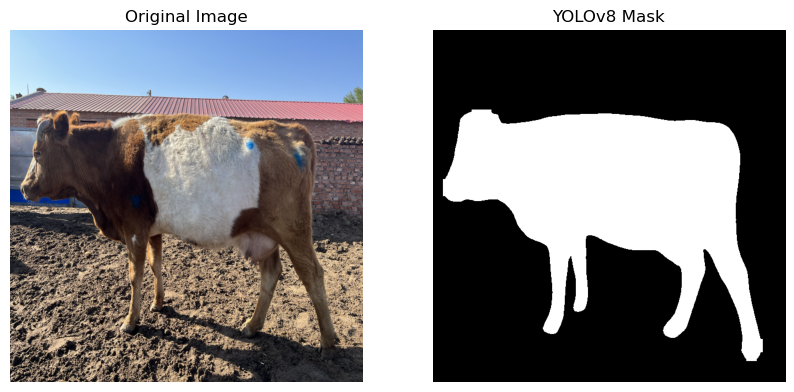

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\14.png


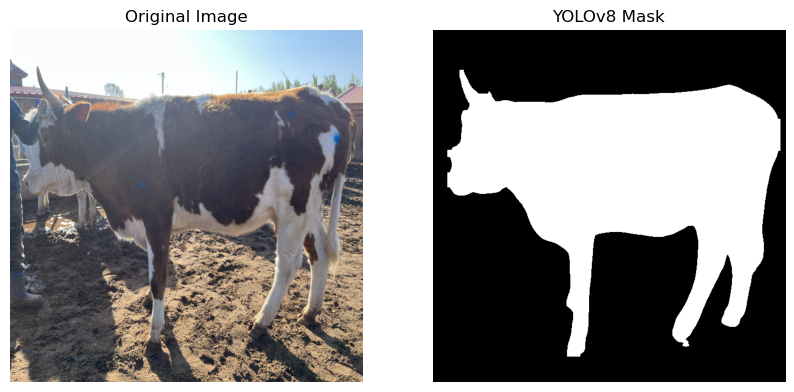

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\15.png


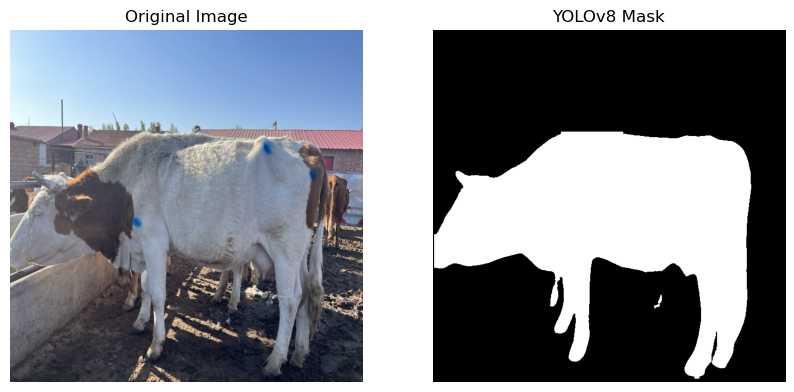

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\16.png


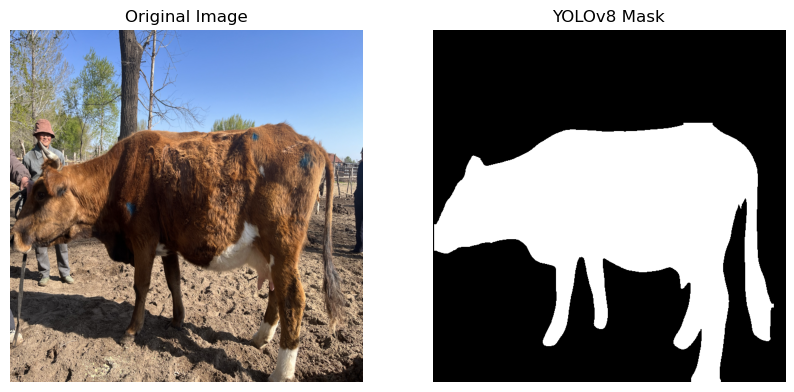

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\18.png


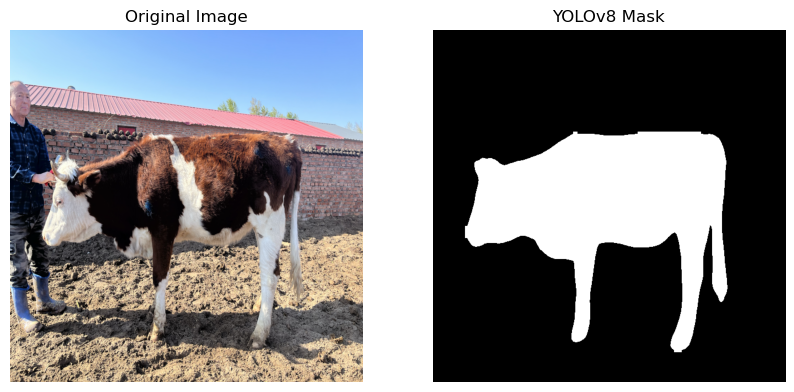

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\2.png


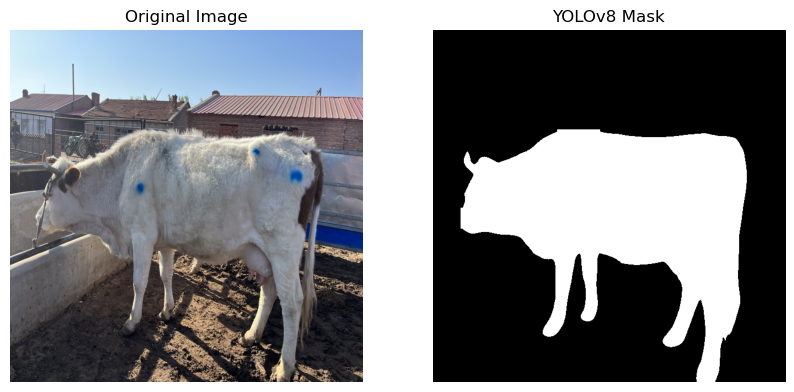

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\20.png


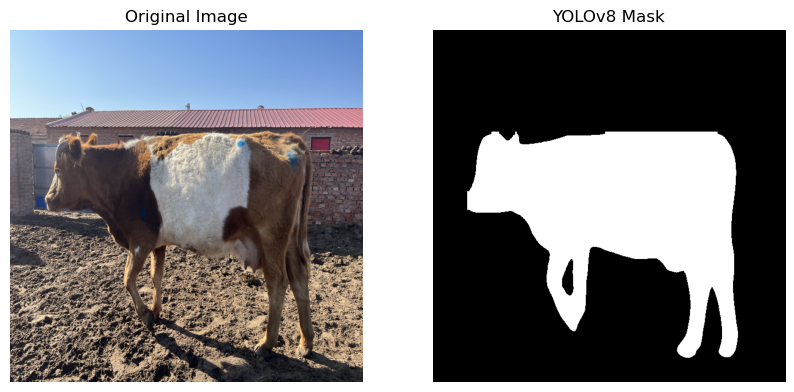

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\21.png


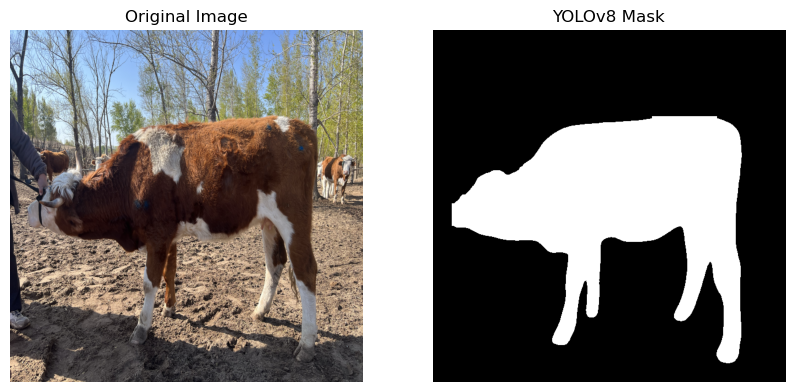

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\22.png


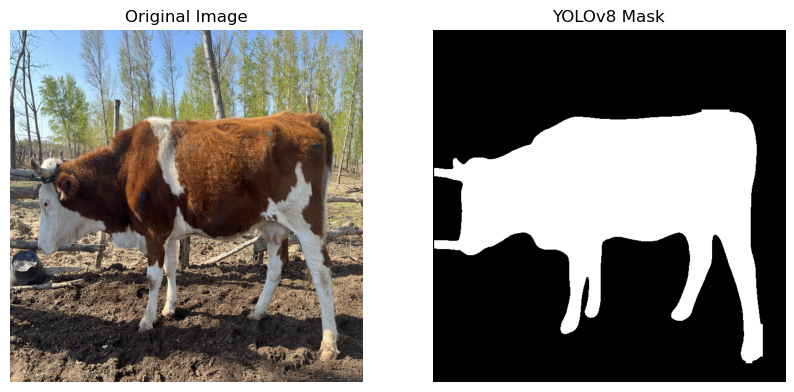

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\24.png


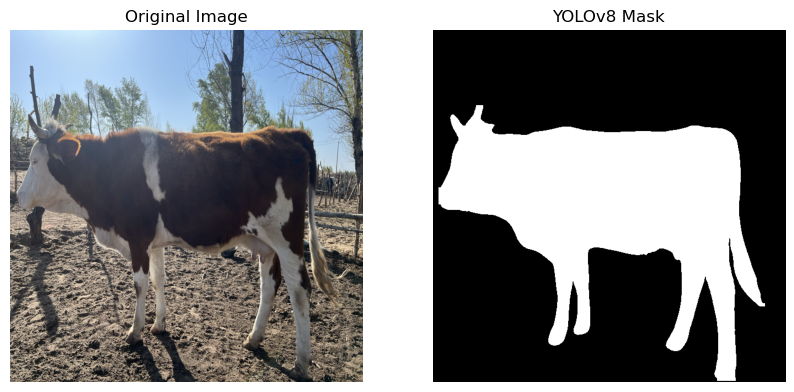

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\25.png


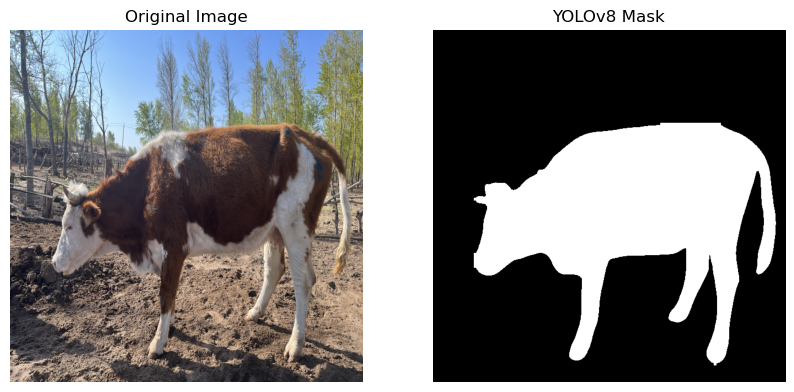

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\26.png


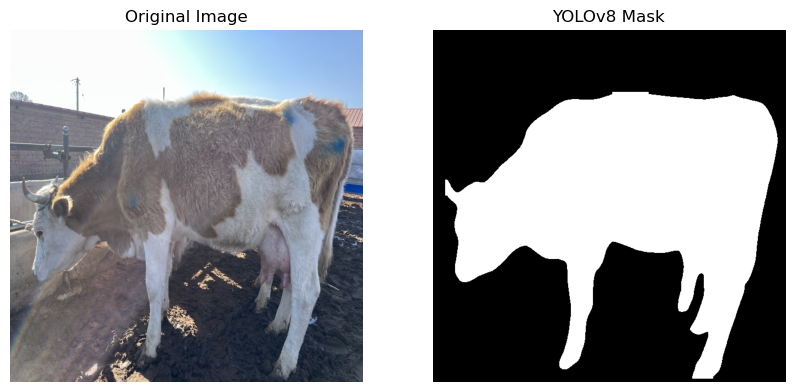

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\27.png


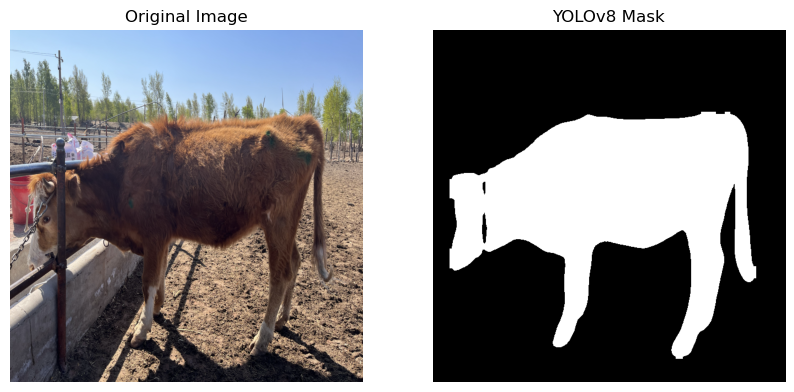

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\28.png


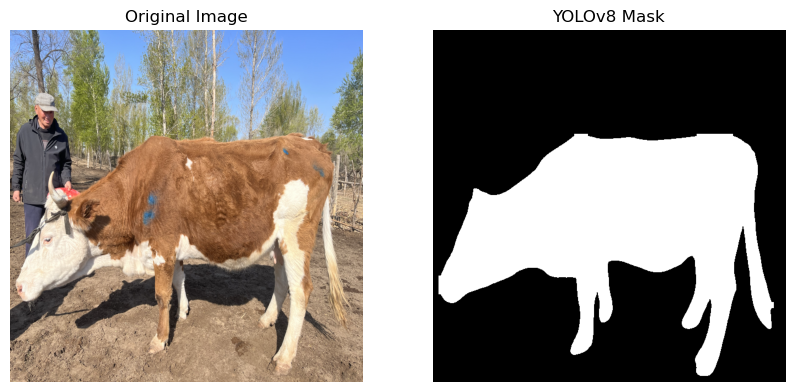

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\3.png


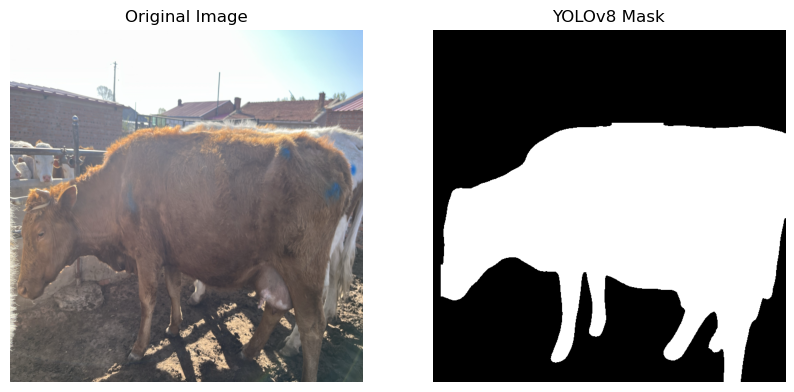

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\30.png


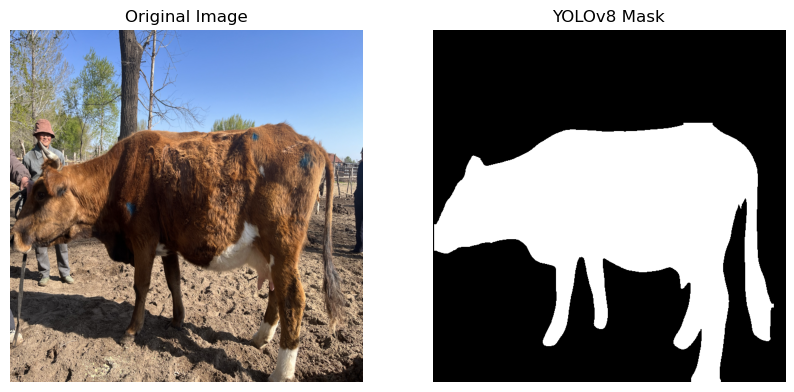

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\31.png


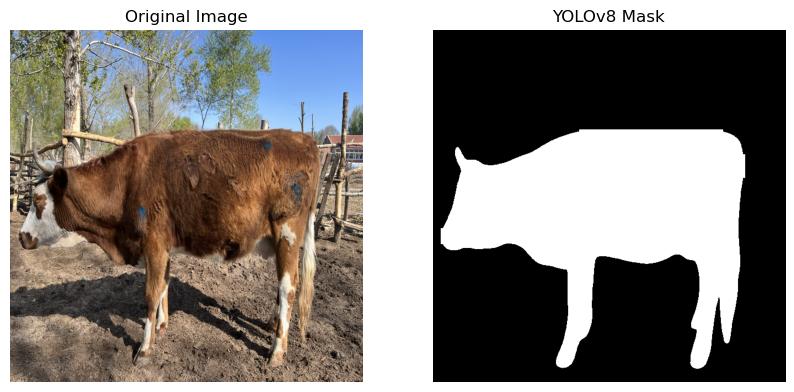

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\33.png


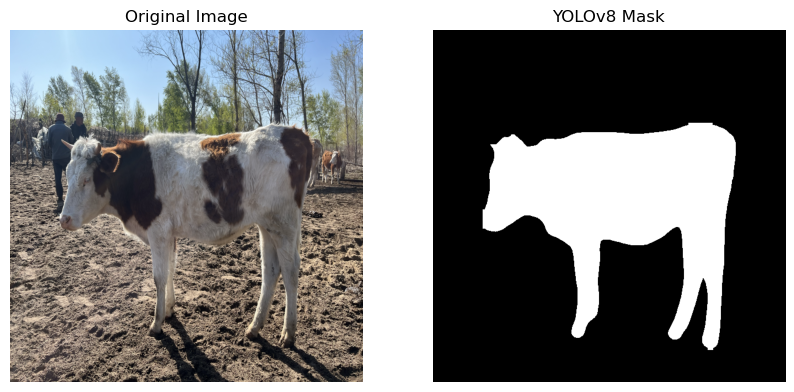

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\36.png


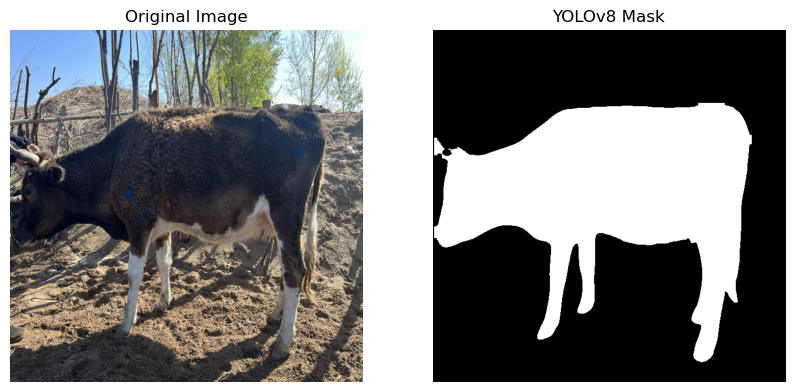

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\37.png


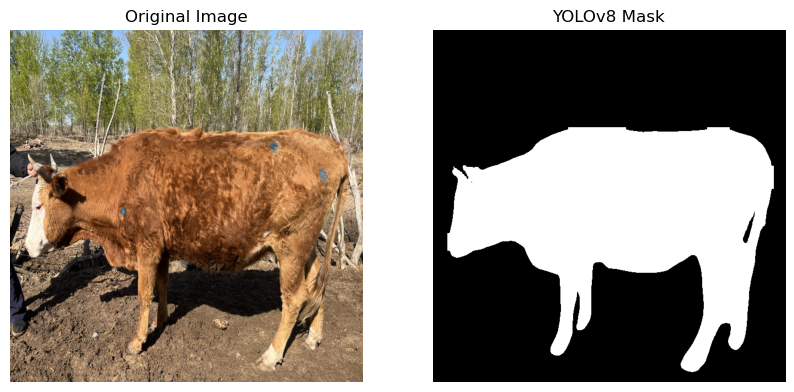

📷 Processing: C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\train\38.png


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_pil_image
from ultralytics import YOLO

# === CONFIG ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
min_area_threshold = 200000
score_threshold = 0.5

# === PATHS ===
root_dir = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset"
train_folder = os.path.join(root_dir, "train")
output_root_dir = os.path.join(root_dir, "segmented_masks_train_yolo")
os.makedirs(output_root_dir, exist_ok=True)

# === TRANSFORM ===
resize_transform = Resize((IMG_HEIGHT, IMG_WIDTH))

# === LOAD YOLOv8 SEGMENTATION MODEL ===
model = YOLO('yolov8x-seg.pt')

# === TRACKING ===
success_count = 0
failed_segmentation_paths = []

# === LIST ALL IMAGE FILES IN TRAIN ===
image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# === SEGMENTATION LOOP ===
for filename in image_files:
    try:
        image_path = os.path.join(train_folder, filename)
        print(f"📷 Processing: {image_path}")

        # Load and resize image
        image = read_image(image_path).to(device).float() / 255.0
        image_resized = resize_transform(image)
        image_np = image_resized.mul(255).byte().permute(1, 2, 0).cpu().numpy()

        # YOLO inference
        results = model.predict(source=image_np, conf=score_threshold, verbose=False)
        pred = results[0]

        if pred.masks is None or len(pred.masks.data) == 0:
            raise ValueError("No masks detected")

        masks = pred.masks.data.cpu().numpy()
        boxes = pred.boxes.xyxy.cpu().numpy()

        best_mask = None
        best_area = 0

        for i, (mask, box) in enumerate(zip(masks, boxes)):
            area = (box[2] - box[0]) * (box[3] - box[1])
            if area > min_area_threshold and area > best_area:
                best_area = area
                best_mask = mask

        if best_mask is not None:
            save_path = os.path.join(output_root_dir, f"{os.path.splitext(filename)[0]}_mask.jpg")
            cv2.imwrite(save_path, (best_mask * 255).astype('uint8'))

            # Optional visualization
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_pil_image(image_resized.cpu()))
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(best_mask, cmap='gray')
            plt.title("YOLOv8 Mask")
            plt.axis("off")
            plt.show()

            success_count += 1
        else:
            print(f"⚠️ No mask passed area threshold in: {filename}")
            failed_segmentation_paths.append(image_path)

    except Exception as e:
        print(f"❌ Failed: {image_path} — {e}")
        failed_segmentation_paths.append(image_path)

# === SAVE FAILED SEGMENTATION LIST ===
fail_csv_path = os.path.join(output_root_dir, "train_failed_segmentations.csv")
pd.DataFrame(failed_segmentation_paths, columns=['Failed Segmentation Paths']).to_csv(fail_csv_path, index=False)

# === SUMMARY ===
print(f"\n✅ Total Successful Segmentations: {success_count}")
print(f"❌ Failed Segmentations saved to: {fail_csv_path}")


# Get body width height

In [11]:
import os
import cv2
import numpy as np
import pandas as pd

# Set your paths
mask_folder = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\segmented_masks_train_yolo"
pixels_per_cm_girth = 17.0    # adjust for your calibration
pixels_per_cm_length = 30.5   # adjust for your calibration

def get_measurements(mask, px_per_cm_girth, px_per_cm_length):
    h, w = mask.shape
    # Girth: widest part
    mask_rowsum = np.sum(mask, axis=1)
    y_widest = np.argmax(mask_rowsum)
    x_coords = np.where(mask[y_widest, :] > 0)[0]
    girth_cm = (x_coords[-1] - x_coords[0]) / px_per_cm_girth if len(x_coords) >= 2 else np.nan

    # Length: max span in center 20%
    y_mid = h // 2
    band_half = h // 10
    band_start, band_end = max(y_mid - band_half, 0), min(y_mid + band_half, h)
    max_length_px = 0
    for y in range(band_start, band_end):
        x_row = np.where(mask[y, :] > 0)[0]
        if len(x_row) >= 2:
            span = x_row[-1] - x_row[0]
            if span > max_length_px:
                max_length_px = span
    body_length_cm = max_length_px / px_per_cm_length if max_length_px > 0 else np.nan

    return girth_cm, body_length_cm

rows = []
for file in os.listdir(mask_folder):
    if file.endswith('.png') or file.endswith('.jpg'):
        mask = cv2.imread(os.path.join(mask_folder, file), cv2.IMREAD_GRAYSCALE)
        if mask is None or np.sum(mask) == 0:
            continue
        mask_bin = (mask > 127).astype(np.uint8)
        girth, length = get_measurements(mask_bin, pixels_per_cm_girth, pixels_per_cm_length)
        # Extract image number (adapt this line if needed)
        img_num = os.path.splitext(file)[0].split('_')[0]
        rows.append({'Num': img_num, 'File_Name': file, 'Heart_Girth_cm': girth, 'Body_Length_cm': length})

df = pd.DataFrame(rows)
df.to_csv("cattle_dimensions.csv", index=False)
print("✅ Saved cattle_dimensions.csv")

✅ Saved cattle_dimensions.csv


# Comparison of xgboost and actual weight

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load data ===
dimension_path = "cattle_dimensions.csv"
measurement_path = "measurements.csv"

df_dims = pd.read_csv(dimension_path)
df_meas = pd.read_csv(measurement_path)

# Ensure "Num" is the same type for merging
df_dims['Num'] = df_dims['Num'].astype(str)
df_meas['Num'] = df_meas['Num'].astype(str)

# Merge on Num
df = pd.merge(df_meas, df_dims, on='Num')

# === Prepare features and target ===
X = df[['Heart_Girth_cm', 'Body_Length_cm']]
y = df['Body weight (kg)']

# === Data cleaning: Ensure numeric and no NaN ===
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Remove rows with NaN in features or target
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

# Print info to confirm
print("Data shape after cleaning:", X.shape)
print("Any NaN in X?", X.isnull().values.any())
print("Any NaN in y?", y.isnull().values.any())

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Parameter grid for GridSearchCV ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9]
}

# === XGBoost with GridSearchCV ===
xgb = XGBRegressor(random_state=42, n_jobs=1)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    error_score='raise'  # Immediately show errors
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\nBest hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# === Prediction ===
y_pred = best_model.predict(X_test)
y_pred_rounded = np.round(y_pred, 2)

# === Evaluation metrics ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
mae = mean_absolute_error(y_test, y_pred_rounded)
r2 = r2_score(y_test, y_pred_rounded)
mape = np.mean(np.abs((y_test - y_pred_rounded) / y_test)) * 100

print("\n📊 XGBoost GridSearchCV Weight Estimation Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} kg")
print(f"MAE: {mae:.2f} kg")
print(f"MAPE: {mape:.2f}%")

# === Comparison Table ===
df_comp = X_test.copy()
df_comp['Actual Weight (kg)'] = y_test.values
df_comp['Predicted Weight (kg)'] = y_pred_rounded
df_comp['Absolute Error'] = np.abs(df_comp['Actual Weight (kg)'] - df_comp['Predicted Weight (kg)'])
print("\nSample comparison:")
print(df_comp.head(10))

# === Save comparison to CSV (optional) ===
df_comp.to_csv("xgboost_gridsearch_pred_vs_actual.csv", index=False)

# === Plotting ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='dodgerblue', label='Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Weight (kg)')
plt.ylabel('Predicted Weight (kg)')
plt.title('XGBoost GridSearchCV: Actual vs Predicted Cattle Weight')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Data shape after cleaning: (49, 2)
Any NaN in X? False
Any NaN in y? False
Fitting 5 folds for each of 24 candidates, totalling 120 fits


XGBoostError: [19:21:16] C:\actions-runner\_work\xgboost\xgboost\src\data\array_interface.cu:44: Check failed: err == cudaGetLastError() (0 vs. 709) : 


📊 XGBoost Weight Estimation Performance:
Parameters: n_estimators=500, learning_rate=0.03, max_depth=4, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.5, reg_lambda=2
R² Score: -0.4451
RMSE: 105.48 kg
MAE: 94.72 kg
MAPE: 18.10%

Sample comparison:
    Heart_Girth_cm  Body_Length_cm  Actual Weight (kg)  Predicted Weight (kg)  \
13       34.235294       19.081967                 440             554.989990   
45       33.294118       18.557377                 512             486.869995   
47       34.647059       19.311475                 586             469.890015   
44       34.705882       19.344262                 617             469.890015   
17       31.647059       17.639344                 450             402.420013   
27       37.470588       20.950820                 601             468.679993   
26       33.588235       18.721311                 445             486.869995   
25       33.882353       19.377049                 479             587.789978   
31       32.705882  

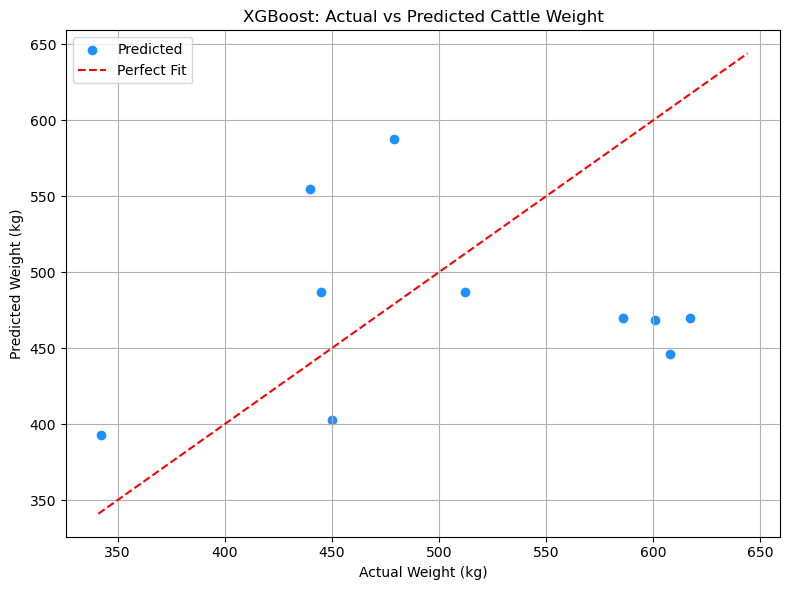

In [19]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load data ===
dimension_path = "cattle_dimensions.csv"    # Path to your dimension CSV (from segmentation)
measurement_path = "measurements.csv"       # Path to your actual weights CSV

df_dims = pd.read_csv(dimension_path)
df_meas = pd.read_csv(measurement_path)

# Ensure "Num" is the same type for merging
df_dims['Num'] = df_dims['Num'].astype(str)
df_meas['Num'] = df_meas['Num'].astype(str)

# Merge on Num
df = pd.merge(df_meas, df_dims, on='Num')

# === Prepare features and target ===
X = df[['Heart_Girth_cm', 'Body_Length_cm']]
y = df['Body weight (kg)']

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === XGBoost model with explicit parameters ===
model = XGBRegressor(
    n_estimators=200,      # number of trees
    learning_rate=0.05,    # how much each tree affects the result
    max_depth=3,           # tree depth (complexity)
    subsample=0.7,         # % of samples used per tree
    colsample_bytree=0.7,  # % of features per tree
    reg_alpha=0.1,         # L1 regularization (sparsity)
    reg_lambda=1,          # L2 regularization (overfit control)
    random_state=42
)
model.fit(X_train, y_train)

# === Prediction ===
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred, 2)

# === Evaluation metrics ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
mae = mean_absolute_error(y_test, y_pred_rounded)
r2 = r2_score(y_test, y_pred_rounded)
mape = np.mean(np.abs((y_test - y_pred_rounded) / y_test)) * 100

print("\n📊 XGBoost Weight Estimation Performance:")
print(f"Parameters: n_estimators=500, learning_rate=0.03, max_depth=4, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.5, reg_lambda=2")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} kg")
print(f"MAE: {mae:.2f} kg")
print(f"MAPE: {mape:.2f}%")

# === Comparison Table ===
df_comp = X_test.copy()
df_comp['Actual Weight (kg)'] = y_test.values
df_comp['Predicted Weight (kg)'] = y_pred_rounded
df_comp['Absolute Error'] = np.abs(df_comp['Actual Weight (kg)'] - df_comp['Predicted Weight (kg)'])
print("\nSample comparison:")
print(df_comp.head(10))

# === Save comparison to CSV (optional) ===
df_comp.to_csv("xgboost_pred_vs_actual.csv", index=False)

# === Plotting ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='dodgerblue', label='Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Weight (kg)')
plt.ylabel('Predicted Weight (kg)')
plt.title('XGBoost: Actual vs Predicted Cattle Weight')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Prediciton 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Paths ===
measurement_path = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\measurements.csv"
dimension_path = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset\segmented_masks_train_yolo\cattle_dimensions.csv"

# === Load Data ===
df_measurement = pd.read_csv(measurement_path)
df_dimension = pd.read_csv(dimension_path)

# === Clean and Merge ===
df_measurement['Animal_No'] = df_measurement['Num'].astype(int)
df_dimension['Animal_No'] = df_dimension['Animal_No'].astype(int)
df_merged = pd.merge(df_measurement, df_dimension, on='Animal_No')

# === Features and Target ===
X = df_merged[['Heart_Girth_cm', 'Body_Length_cm']]
y = df_merged['Body weight (kg)']

# === Models to Compare ===
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.5, max_depth=3, random_state=42)
}

# === Evaluation Function ===
def evaluate_model(name, model, X, y):
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print(f"\n📊 {name} Performance:")
    print(f"✅ R² Score: {r2:.4f}")
    print(f"✅ RMSE: {rmse:.2f} kg")
    print(f"✅ MAE: {mae:.2f} kg")
    print(f"✅ MAPE: {mape:.2f}%")
    return y_pred

# === Evaluate All Models ===
results = {}
for name, model in models.items():
    y_pred = evaluate_model(name, model, X, y)
    results[name] = np.round(y_pred, 2)

# === Show Predicted vs Actual Table for XGBoost ===
df_merged["Predicted Weight (kg)"] = results["XGBoost"]
display(df_merged[["Animal_No", "Heart_Girth_cm", "Body_Length_cm", "Body weight (kg)", "Predicted Weight (kg)"]])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load your prepared dataset
base_path = r"C:\Users\hkmin\Downloads\FYP project\Cattle fyp dataset\FYP\cattle_yolo_dataset"
df = pd.concat([
    pd.read_csv(f"{base_path}\\train_goat_features_ain.csv"),
    pd.read_csv(f"{base_path}\\val_goat_features_ain.csv"),
    pd.read_csv(f"{base_path}\\test_goat_features_ain.csv")
])

# Advanced Feature Engineering
def create_features(df):
    # Basic features
    features = df[['Heart Girth_cm', 'Body Length_cm']].copy()
    
    # Derived features
    features['Volume_est'] = features['Heart Girth_cm']**2 * features['Body Length_cm']
    features['Density_est'] = df['Live Body Wt.'] / features['Volume_est']
    features['Girth_to_Length'] = features['Heart Girth_cm'] / features['Body Length_cm']
    
    # Polynomial features
    for col in ['Heart Girth_cm', 'Body Length_cm']:
        features[f'{col}_squared'] = features[col] ** 2
        features[f'{col}_cubed'] = features[col] ** 3
    
    return features

X = create_features(df)
y = df['Live Body Wt.']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Advanced Model Pipeline
models = {
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameter grids for tuning
param_grids = {
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 0.9]
    },
    "RandomForest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    },
    "GradientBoosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
}

# Model training and evaluation
results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Grid search with 5-fold CV
    gs = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    gs.fit(X_train, y_train)
    
    # Best model from grid search
    model = gs.best_estimator_
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100,
        'R2': r2_score(y_test, y_pred),
        'Best_Params': gs.best_params_
    }
    
    results[name] = metrics
    
    # Track best model
    if metrics['R2'] > best_score:
        best_score = metrics['R2']
        best_model = model
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 5))
        importances = pd.Series(model.feature_importances_, index=X.columns)
        importances.sort_values().plot(kind='barh')
        plt.title(f'{name} - Feature Importance')
        plt.show()

# Display results
results_df = pd.DataFrame(results).T
print("\n=== Model Performance Comparison ===")
print(results_df)

# Save best model
joblib.dump(best_model, f"{base_path}\\best_cattle_weight_model.pkl")
print(f"\n✅ Best model saved to: {base_path}\\best_cattle_weight_model.pkl")

# Visualization of predictions
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5, label=name)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Weight (kg)')
plt.ylabel('Predicted Weight (kg)')
plt.title('Model Comparison: Actual vs Predicted Weights')
plt.legend()
plt.grid(True)
plt.show()

# Error analysis
best_pred = best_model.predict(X_test)
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_pred,
    'Error_kg': y_test - best_pred,
    'Error_%': ((y_test - best_pred) / y_test) * 100
})

print("\n=== Worst Predictions ===")
print(error_df.sort_values('Error_%', key=abs, ascending=False).head(5))